In [1]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
import numpy as np
from torch.nn import KLDivLoss
from torchvision.io import read_video
from scipy.special import kl_div

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from src.losses.kpt_distribution_metric import kpt_distribution_metric

from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [2]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape

time_window = 5
patch_size = (35, 35)

pos_range = max(int(time_window / 2), 1) if time_window > 1 else 0
center_index = int(patch_size[0] / 2)

step_matrix = torch.ones(patch_size + (2,))

step_w = 2 / W
step_h = 2 / H

for k in range(0, patch_size[0]):
    for l in range(0, patch_size[1]):
        step_matrix[k, l, 0] = (l - center_index) * step_w
        step_matrix[k, l, 1] = (k - center_index) * step_h

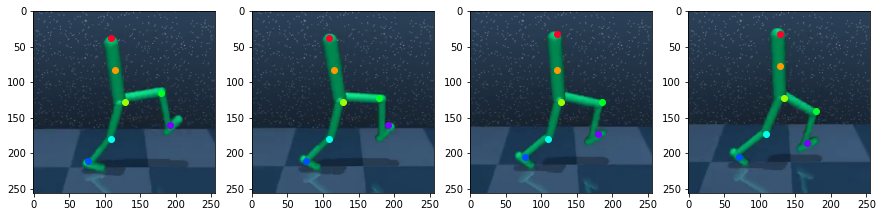

In [3]:
perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = perfect_kpt_coordinates.shape

cm = pylab.get_cmap('gist_rainbow')
perfect_kpts = kpts_2_img_coordinates(perfect_kpt_coordinates, tuple(img_tensor.shape[-2:]))
fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
for t in range(sample_size):
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    for k in range(K):
        ax[t].scatter(perfect_kpts[0, t, k, 1], perfect_kpts[0, t, k, 0], color=cm(1.*k/K))
plt.show()

In [4]:
img_t_diff = torch.empty((N, T-1, C, H, W))
for n in range(N):
    for t in range(T-1):
        img_t_diff[n, t, ...] = img_tensor[n, t, ...] - img_tensor[n, t+1, ...]


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


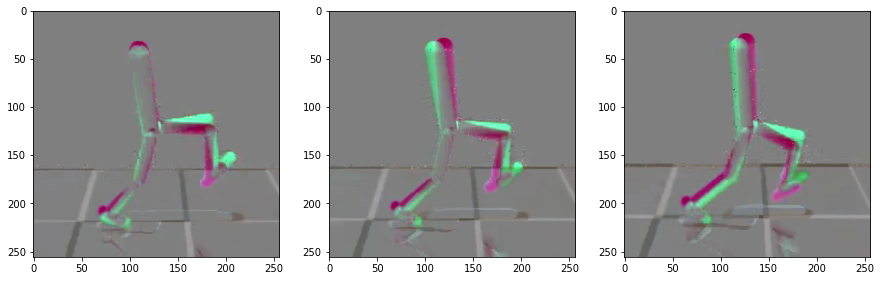

In [5]:
fig, ax = plt.subplots(1, T-1, figsize=(15, 5))
for t in range(T-1):
    print(img_t_diff[0, t].shape)
    ax[t].imshow((img_t_diff[0, t].permute(1, 2, 0) + 0.5).clip(0.0, 1.0))

In [6]:
perfect_kpt_distances = torch.empty((N, T, K, K))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for _k in range(K):
                perfect_kpt_distances[n, t, k, _k] = torch.norm(perfect_kpts[n, t, k, :2]-perfect_kpts[n, t, _k, :2], p=2)

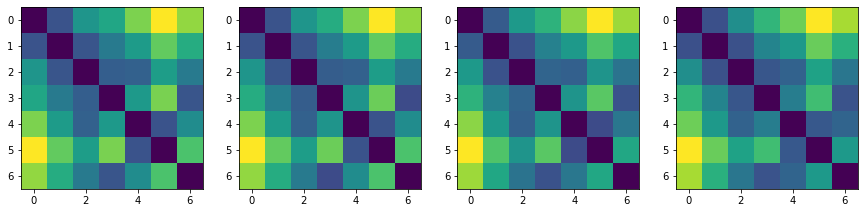

In [7]:
fig, ax = plt.subplots(1, T, figsize=(15, 5))
for t in range(T):
    ax[t].imshow(perfect_kpt_distances[0, t, ...])
plt.show()

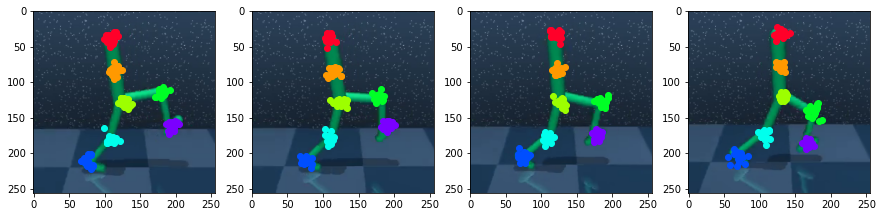

In [8]:
from torch.distributions import MultivariateNormal

n_samples = 20

fig, ax = plt.subplots(1, T, figsize=(15, 5))

perfect_samples = torch.empty((N, T, K, n_samples, 2))

for t in range(T):
    
    mvN = MultivariateNormal(loc=perfect_kpts[0, t, :, :2], covariance_matrix=torch.eye(2)*25)
    
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    
    for s in range(n_samples):
        
        sample = mvN.sample()
    
        for k in range(K):

            ax[t].scatter(sample[k, 1], sample[k, 0], color=cm(1.*k/K))
            
            perfect_samples[0, t, :, s, :] = sample

In [9]:
from torch.nn import KLDivLoss

d_kl = KLDivLoss(reduction='batchmean')

for t in range(T-1):
    print(d_kl(perfect_samples[0, t, ...], perfect_samples[0, t+1, ...]))
    
for t in range(T-1):
    print(torch.norm(perfect_samples[0, t, ...] - perfect_samples[0, t+1, ...], p=float('inf')))

tensor(-745200.8750)
tensor(-748390.1875)
tensor(-757320.8125)
tensor(22.5582)
tensor(25.5851)
tensor(26.1327)


Bad key-points

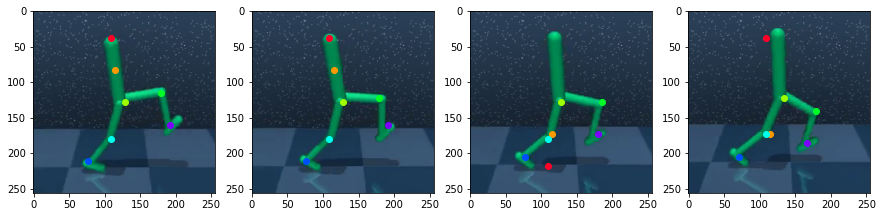

In [10]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))

bad_kpts = kpts_2_img_coordinates(bad_kpt_coordinates, tuple(img_tensor.shape[-2:]))
fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
for t in range(sample_size):
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    for k in range(K):
        ax[t].scatter(bad_kpts[0, t, k, 1], bad_kpts[0, t, k, 0], color=cm(1.*k/K))
plt.show()

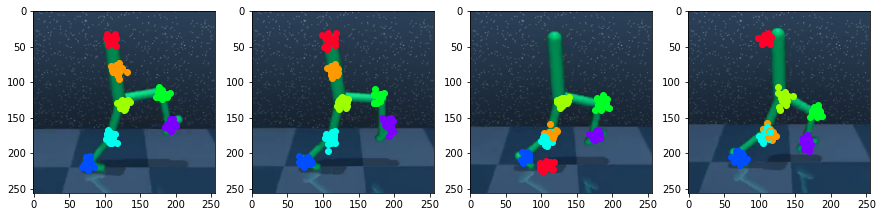

In [11]:
fig, ax = plt.subplots(1, T, figsize=(15, 5))

bad_samples = torch.empty((N, T, K, n_samples, 2))

for t in range(T):
    
    mvN = MultivariateNormal(loc=bad_kpts[0, t, :, :2], covariance_matrix=torch.eye(2)*25)
    
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    
    for s in range(n_samples):
        
        sample = mvN.sample()
    
        for k in range(K):

            ax[t].scatter(sample[k, 1], sample[k, 0], color=cm(1.*k/K))
            
            bad_samples[0, t, :, s, :] = sample

In [12]:
d_kl = KLDivLoss(reduction='batchmean')

for t in range(T-1):
    print(d_kl(bad_samples[0, t, ...], bad_samples[0, t+1, ...]))
    
for t in range(T-1):
    print(torch.norm(bad_samples[0, t, ...] - bad_samples[0, t+1, ...], p=float('inf')))

tensor(-745718.1875)
tensor(-782960.3125)
tensor(-827791.6875)
tensor(20.4848)
tensor(191.2366)
tensor(187.6712)


Random key-points

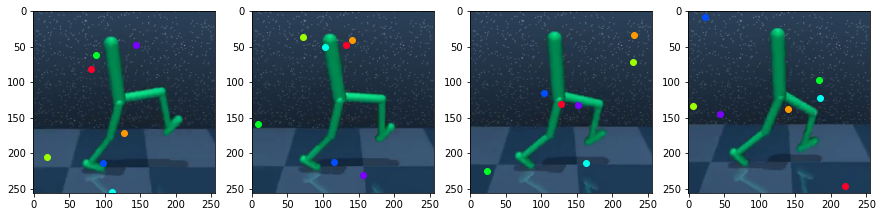

In [13]:
random_kpt_coordinates = get_random_keypoints(T=sample_size).unsqueeze(0)
random_kpt_coordinates = random_kpt_coordinates.repeat((batch_size, 1, 1, 1))

random_kpts = kpts_2_img_coordinates(random_kpt_coordinates, tuple(img_tensor.shape[-2:]))
fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
for t in range(sample_size):
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    for k in range(K):
        ax[t].scatter(random_kpts[0, t, k, 1], random_kpts[0, t, k, 0], color=cm(1.*k/K))
plt.show()

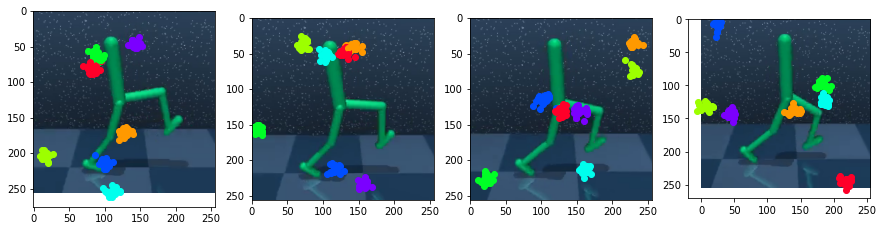

In [14]:
fig, ax = plt.subplots(1, T, figsize=(15, 5))

random_samples = torch.empty((N, T, K, n_samples, 2))

for t in range(T):
    
    mvN = MultivariateNormal(loc=random_kpts[0, t, :, :2], covariance_matrix=torch.eye(2)*25)
    
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    
    for s in range(n_samples):
        
        sample = mvN.sample()
    
        for k in range(K):

            ax[t].scatter(sample[k, 1], sample[k, 0], color=cm(1.*k/K))
            
            random_samples[0, t, :, s, :] = sample

In [15]:
d_kl = KLDivLoss(reduction='batchmean')

for t in range(T-1):
    print(d_kl(random_samples[0, t, ...], random_samples[0, t+1, ...]))
    
for t in range(T-1):
    print(torch.norm(random_samples[0, t, ...] - random_samples[0, t+1, ...], p=float('inf')))

tensor(-476406.5000)
tensor(-632797.8750)
tensor(-605512.)
tensor(211.3861)
tensor(172.2224)
tensor(238.4871)


Evaluate Metric

In [16]:
M_distr_perfect = kpt_distribution_metric(perfect_kpt_coordinates, (256, 256), 20)
M_distr_bad = kpt_distribution_metric(bad_kpt_coordinates, (256, 256), 20)
M_distr_random = kpt_distribution_metric(random_kpt_coordinates, (256, 256), 20)
print(M_distr_perfect)
print(M_distr_bad)
print(M_distr_random)

tensor(0.0819)
tensor(0.3992)
tensor(0.6151)
